In [1]:
import sys
sys.path.insert(1, 'C://Users//arthu//git//eyenes')
from eyenes.generation import Generation
import pickle
import numpy as np

Using TensorFlow backend.


In [2]:
dicto = {'size': 16, 'black_and_white': True, 'rom_id': 'SuperMarioBros-v0', 
         'max_steps': 3000, 'freq': .25, 'buffer': 3,
        'layer_prob': .25, 'intensity': 10, 'fps': 3, 'patience': 5,
        'num_survivors': 4, 'similar_penalty': 1, 'mode': 'sequential'}

In [3]:
generation = Generation(**dicto)

In [4]:
generation.delete_standard_folders()
generation.create_standard_folders()

pickled created
pickled/generation created
pickled/generation/weights created
pickled/generation/lineages created
pickled/top_models created
pickled/top_models/weights created
pickled/top_models/videos created


In [5]:
generation.agents[0].model.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (1, 240, 256, 3)          0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (1, 256, 256, 3)          0         
_________________________________________________________________
average_pooling2d_1 (Average (1, 128, 128, 3)          0         
_________________________________________________________________
separable_conv2d_1 (Separabl (1, 32, 32, 3)            60        
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 16, 16, 6)            4614      
_________________________________________________________________
conv2d_2 (Conv2D)            (1, 8, 8, 12)             4620      
_________________________________________________________________
flatten_1 (Flatten)          (1, 768)                 

In [6]:
def safe_reward(agent):
    if agent.total_reward is not None:
        return agent.total_reward
    else:
        return np.NINF

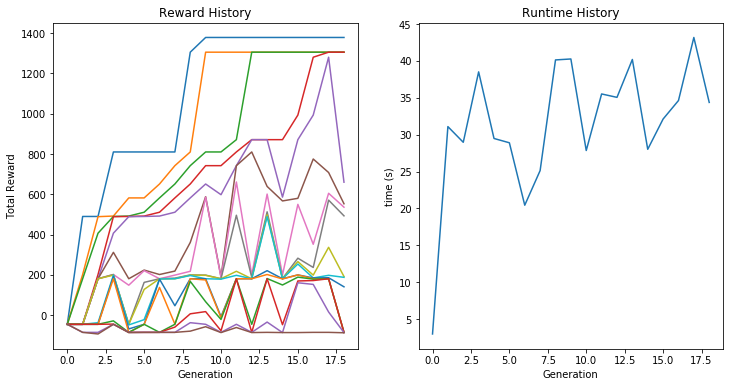

In [ ]:
for i in range(1000):
    generation.evolution_step(plot = True, monitor = True)
    rewards = [safe_reward(agent) for agent in generation.agents]
    generation.agents[np.argmax(rewards)].play_video(width = 600, height = 450)
    generation.save_generation()